In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report, confusion_matrix
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer 
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_confusion_matrix
import matplotlib.cm as cm
from matplotlib import rcParams
from collections import Counter
from nltk.tokenize import RegexpTokenizer
import re
import string
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [3]:
#import nltk
#>>> nltk.download()

In [4]:
#pip install mlxtend

In [5]:
data = pd.read_csv("twitter.csv", encoding = "ISO-8859-1")
data.columns = ["label", "time", "date", "query", "username", "text"]
data

,label,time,date,query,username,text
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew
...,...,...,...,...,...,...
1599994,4,2193601966,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,AmandaMarie1028,Just woke up. Having no school is the best fee...
1599995,4,2193601969,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,TheWDBoards,TheWDB.com - Very cool to hear old Walt interv...
1599996,4,2193601991,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,bpbabe,Are you ready for your MoJo Makeover? Ask me f...
1599997,4,2193602064,Tue Jun 16 08:40:49 PDT 2009,NO_QUERY,tinydiamondz,Happy 38th Birthday to my boo of alll time!!! ...


In [6]:
data.shape

(1599999, 6)

In [7]:
data.columns

Index(['label', 'time', 'date', 'query', 'username', 'text'], dtype='object')

In [8]:
data.info

<bound method DataFrame.info of          label        time                          date     query  \
0            0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY   
1            0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY   
2            0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
3            0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY   
4            0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY   
...        ...         ...                           ...       ...   
1599994      4  2193601966  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599995      4  2193601969  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599996      4  2193601991  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599997      4  2193602064  Tue Jun 16 08:40:49 PDT 2009  NO_QUERY   
1599998      4  2193602129  Tue Jun 16 08:40:50 PDT 2009  NO_QUERY   

                username                                               text  
0          scotthamilton  is upset that he can't 

In [9]:
np.sum(data.isnull().any(axis=1))

0

Data preparation

In [10]:
data=data[['text','label']]

In [11]:
data['label'][data['label']==4]=1

In [12]:
data_pos = data[data['label'] == 1]
data_neg = data[data['label'] == 0]

In [13]:
data_pos = data_pos.iloc[:int(20000)]
data_neg = data_neg.iloc[:int(20000)]

In [14]:
data = pd.concat([data_pos, data_neg])

In [15]:
data['text']=data['text'].str.lower()

In [16]:
data['text'].head()

799999         i love @health4uandpets u guys r the best!! 
800000    im meeting up with one of my besties tonight! ...
800001    @darealsunisakim thanks for the twitter add, s...
800002    being sick can be really cheap when it hurts t...
800003      @lovesbrooklyn2 he has that effect on everyone 
Name: text, dtype: object

In [17]:
data['text'].tail()

19995                            one more day of holidays 
19996    feeling so down right now .. i hate you damn h...
19997    geez,i hv to read the whole book of personalit...
19998    i threw my sign at donnie and he bent over to ...
19999    @heather2711 good thing i didn't find any then...
Name: text, dtype: object

Cleaning and removing

In [18]:
stopwords_list = stopwords.words('english')

In [19]:
from nltk.corpus import stopwords
", ".join(stopwords.words('english'))

"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [20]:
STOPWORDS = set(stopwords.words('english'))
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])
data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head()

799999                love @health4uandpets u guys r best!!
800000    im meeting one besties tonight! cant wait!! - ...
800001    @darealsunisakim thanks twitter add, sunisa! g...
800002    sick really cheap hurts much eat real food plu...
800003                      @lovesbrooklyn2 effect everyone
Name: text, dtype: object

In [21]:
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)

In [22]:
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail()

19995                                     one day holidays
19996                     feeling right  hate damn humprey
19997    geezi hv read whole book personality types emb...
19998     threw sign donnie bent get thingee made sad face
19999    heather2711 good thing find none ones like com...
Name: text, dtype: object

In [23]:
def cleaning_repeating_char(text):
    return re.sub(r'(.)\1+', r'\1', text)

In [24]:
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [25]:
def cleaning_email(data):
    return re.sub('@[^\s]+', ' ', data)

In [26]:
data['text']= data['text'].apply(lambda x: cleaning_email(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [27]:
def cleaning_URLs(data):
    return re.sub('((www\.[^\s]+)|(https?://[^\s]+))',' ',data)

In [28]:
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather271 god thing find none ones like come ...
Name: text, dtype: object

In [29]:
def cleaning_numbers(data):
    return re.sub('[0-9]+', '', data)

In [30]:
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail()

19995                                     one day holidays
19996                       feling right hate damn humprey
19997    gezi hv read whole bok personality types embar...
19998       threw sign donie bent get thinge made sad face
19999    heather god thing find none ones like come siz...
Name: text, dtype: object

In [31]:
tokenizer = RegexpTokenizer(r'\w+')
data['text'] = data['text'].apply(tokenizer.tokenize)

In [32]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [33]:
st = nltk.PorterStemmer()
def stemming_on_text(data):
    text = [st.stem(word) for word in data]
    return data

data['text']= data['text'].apply(lambda x: stemming_on_text(x))

In [34]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

In [35]:
lm = nltk.WordNetLemmatizer()
def lemmatizer_on_text(data):
    text = [lm.lemmatize(word) for word in data]
    return data

data['text'] = data['text'].apply(lambda x: lemmatizer_on_text(x))

In [36]:
data['text'].head()

799999             [love, healthuandpets, u, guys, r, best]
800000    [im, meting, one, besties, tonight, cant, wait...
800001    [darealsunisakim, thanks, twiter, ad, sunisa, ...
800002    [sick, realy, cheap, hurts, much, eat, real, f...
800003                      [lovesbroklyn, efect, everyone]
Name: text, dtype: object

Test and validation 

In [37]:
X=data.text
y=data.label

In [38]:
max_len = 500
tok = Tokenizer(num_words=2000)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [39]:
sequences_matrix.shape


(40000, 500)

In [40]:
X_train, X_test, Y_train, Y_test = train_test_split(sequences_matrix, y, test_size=0.3, random_state=2)

In [41]:
def tensorflow_based_model(): #Defined tensorflow_based_model function for training tenforflow based model
    inputs = Input(name='inputs',shape=[max_len])#step1
    layer = Embedding(2000,50,input_length=max_len)(inputs) #step2
    layer = LSTM(64)(layer) #step3
    layer = Dense(256,name='FC1')(layer) #step4
    layer = Activation('relu')(layer) # step5
    layer = Dropout(0.5)(layer) # step6
    layer = Dense(1,name='out_layer')(layer) #step4 again but this time its giving only one output as because we need to classify the tweet as positive or negative
    layer = Activation('sigmoid')(layer) #step5 but this time activation function is sigmoid for only one output.
    model = Model(inputs=inputs,outputs=layer) #here we are getting the final output value in the model for classification
    return model #function returning the value when we call it

In [42]:
model = tensorflow_based_model() # here we are calling the function of created model
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy']) 

In [43]:
history=model.fit(X_train,Y_train,batch_size=80,epochs=5, validation_split=0.1)# here we are starting the training of model by feeding the training data
print('Training finished !!')

Epoch 1/5
315/315 [==============================] - 58s 183ms/step - loss: 0.6100 - accuracy: 0.6515 - val_loss: 0.5331 - val_accuracy: 0.7289
Epoch 2/5
315/315 [==============================] - 58s 183ms/step - loss: 0.5132 - accuracy: 0.7496 - val_loss: 0.5187 - val_accuracy: 0.7436
Epoch 3/5
315/315 [==============================] - 58s 183ms/step - loss: 0.5039 - accuracy: 0.7599 - val_loss: 0.5138 - val_accuracy: 0.7439
Epoch 4/5
315/315 [==============================] - 58s 183ms/step - loss: 0.4855 - accuracy: 0.7687 - val_loss: 0.5219 - val_accuracy: 0.7375
Epoch 5/5
315/315 [==============================] - 58s 183ms/step - loss: 0.4899 - accuracy: 0.7673 - val_loss: 0.5196 - val_accuracy: 0.7450
Training finished !!


In [44]:
accr1 = model.evaluate(X_test,Y_test)

375/375 [==============================] - 9s 23ms/step - loss: 0.5178 - accuracy: 0.7458


In [45]:
print('Test set\n  Accuracy: {:0.2f}'.format(accr1[1]))

Test set
  Accuracy: 0.75


In [46]:
y_pred = model.predict(X_test) #getting predictions on the trained model
y_pred = (y_pred > 0.5) 

375/375 [==============================] - 9s 23ms/step




confusion matrix


[[4354 1655]
 [1395 4596]]




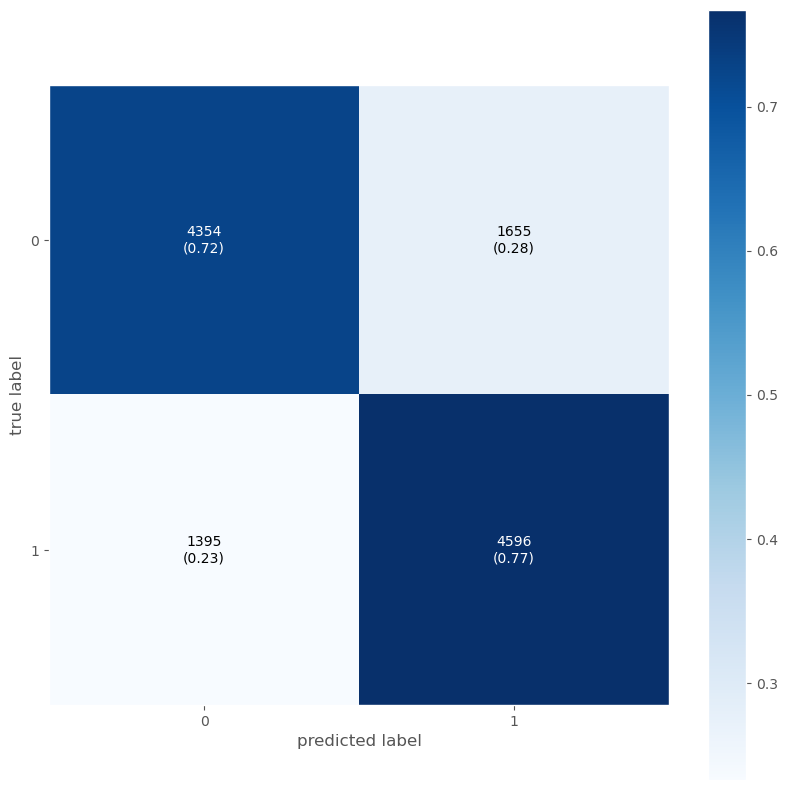

In [47]:
print('\n')
print("confusion matrix")
print('\n')
CR=confusion_matrix(Y_test, y_pred)
print(CR)
print('\n')

fig, ax = plot_confusion_matrix(conf_mat=CR,figsize=(10, 10),
                                show_absolute=True,
                                show_normed=True,
                                colorbar=True)
plt.show()

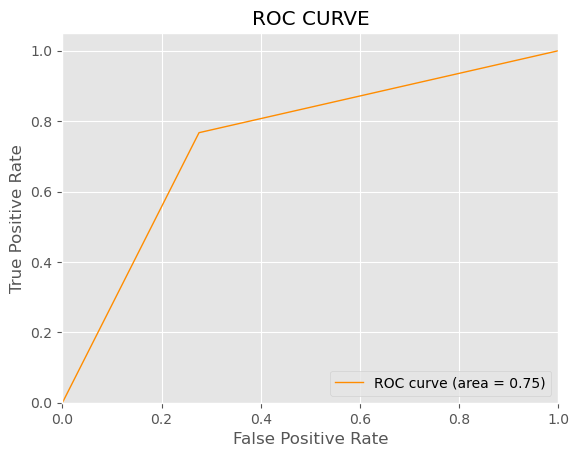

In [48]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

In [47]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from torch.utils.data import TensorDataset, random_split, DataLoader, RandomSampler, SequentialSampler


In [48]:
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.  
    
    device = torch.device('cuda')    


    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

No GPU available, using the CPU instead.


In [49]:
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased', do_lower_case=True)